### Take note if you have any errors running this notebook: I've made a couple of changes in prepare.py, including updating the names of a couple of definitions, etc, that may cause a problem or two here.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 

from pydataset import data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression




import matplotlib.pyplot as plt
import seaborn as sns

import acquire
import prepare

# Using the titanic data, in your classification-exercises repository, create a notebook, model.ipynb where you will do the following:

In [2]:
df = acquire.get_titanic_data()
df

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,27.0,0,0,13.0000,S,Second,NaN,Southampton,1
887,887,1,1,female,19.0,0,0,30.0000,S,First,B,Southampton,1
888,888,0,3,female,NaN,1,2,23.4500,S,Third,NaN,Southampton,0
889,889,1,1,male,26.0,0,0,30.0000,C,First,C,Cherbourg,1


In [3]:
# df.info()

In [4]:
train, validate, test = prepare.prep_titanic_data(df)


In [5]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = imputer.fit(train[['age']])
train[['age']] = imputer.transform(train[['age']])
validate[['age']] = imputer.transform(validate[['age']])
test[['age']] = imputer.transform(test[['age']])


## This would be where you explore your data

    - adam has a neat little exploration of 'no age' in his decicion tree exercise review; he concluded that all the null values in the no_age category couldn't (generally) be children b/c they were largely travelling alone

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 583 to 744
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   passenger_id             498 non-null    int64  
 1   survived                 498 non-null    int64  
 2   pclass                   498 non-null    int64  
 3   sex                      498 non-null    object 
 4   age                      498 non-null    float64
 5   sibsp                    498 non-null    int64  
 6   parch                    498 non-null    int64  
 7   fare                     498 non-null    float64
 8   embark_town              498 non-null    object 
 9   alone                    498 non-null    int64  
 10  baseline_prediction      498 non-null    int64  
 11  sex_male                 498 non-null    uint8  
 12  embark_town_Queenstown   498 non-null    uint8  
 13  embark_town_Southampton  498 non-null    uint8  
dtypes: float64(2), int64(7),

In [7]:
train.shape, validate.shape, test.shape

((498, 14), (214, 14), (179, 14))

### 1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

        - the most prevalent class in your TRAINING dataset

In [8]:
train.survived.value_counts()

0    307
1    191
Name: survived, dtype: int64

- the biggest value in the target variable is 0 (in other words, did not survive)

In [9]:
# df['baseline_prediction'] = 0
# df

In [10]:
from sklearn.metrics import classification_report

In [11]:
print(classification_report(train.survived,train.baseline_prediction))

# see the baseline accuracy in its classification report

              precision    recall  f1-score   support

           0       0.62      1.00      0.76       307
           1       0.00      0.00      0.00       191

    accuracy                           0.62       498
   macro avg       0.31      0.50      0.38       498
weighted avg       0.38      0.62      0.47       498



- Baseline accuracy is 62%

### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 583 to 744
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   passenger_id             498 non-null    int64  
 1   survived                 498 non-null    int64  
 2   pclass                   498 non-null    int64  
 3   sex                      498 non-null    object 
 4   age                      498 non-null    float64
 5   sibsp                    498 non-null    int64  
 6   parch                    498 non-null    int64  
 7   fare                     498 non-null    float64
 8   embark_town              498 non-null    object 
 9   alone                    498 non-null    int64  
 10  baseline_prediction      498 non-null    int64  
 11  sex_male                 498 non-null    uint8  
 12  embark_town_Queenstown   498 non-null    uint8  
 13  embark_town_Southampton  498 non-null    uint8  
dtypes: float64(2), int64(7),

In [13]:
# the string features were causing problems with the DecisionTreeClassifier
X_train = train.drop(columns=['survived', 'sex','passenger_id', 'embark_town'])
y_train = train.survived

X_validate = validate.drop(columns=['survived', 'sex','passenger_id','embark_town'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [14]:
X_train.shape

(498, 10)

In [15]:
X_validate.isnull().sum()

pclass                     0
age                        0
sibsp                      0
parch                      0
fare                       0
alone                      0
baseline_prediction        0
sex_male                   0
embark_town_Queenstown     0
embark_town_Southampton    0
dtype: int64

In [16]:
# below, we the clf.fit function is telling me there are NaNs somewhere.  This show me 97 in 'age'
X_train.isnull().sum()

# i addressed this by imputing average ages two cells below

pclass                     0
age                        0
sibsp                      0
parch                      0
fare                       0
alone                      0
baseline_prediction        0
sex_male                   0
embark_town_Queenstown     0
embark_town_Southampton    0
dtype: int64

In [17]:
# Create the Decision Tree object with desired hyper-parameters.
clf = DecisionTreeClassifier(max_depth=3, random_state=123)
# clf = 'classifier'

In [18]:
# Fit the model (i.e. apply the algorithm to your unique set of data so that the algorithm can identify a pattern)
# model.fit(X, y)

clf = clf.fit(X_train, y_train)

In [19]:
import graphviz
from graphviz import Graph

# there was initially an argument in here that was raising an error, something to do with X_train.classes_
# we tood it out and things got better

dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [20]:
# make prediction on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 1])

### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [21]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.65048544, 0.34951456],
       [0.65048544, 0.34951456],
       [0.65048544, 0.34951456],
       [0.03225806, 0.96774194],
       [0.03225806, 0.96774194]])

In [22]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.83


In [23]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[277,  30],
       [ 57, 134]])

In [24]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [25]:
labels = sorted(y_train.unique())
print('Actual on the left, predicted on the top; 0 = perished, 1 = survived')
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top; 0 = perished, 1 = survived


,0,1
0,277,30
1,57,134


In [26]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       307
           1       0.82      0.70      0.75       191

    accuracy                           0.83       498
   macro avg       0.82      0.80      0.81       498
weighted avg       0.82      0.83      0.82       498



### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [27]:
# isn't this what we did with the classification report? Yes, according to adam

# True Positive rate = recall; false positive rate = precision

### 5. Run through steps 2-4 using a different max_depth value.

In [28]:
clf = DecisionTreeClassifier(max_depth=4, random_state=123)
clf = clf.fit(X_train, y_train)
dot_data = export_graphviz(clf, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [29]:
# make prediction on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 1, 1])

In [30]:
# This is Adam's 'for' loop
for i in range(2, 21):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = tree.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.820433    0.760000  0.799197    0.790217      0.797255
recall       0.863192    0.696335  0.799197    0.779764      0.799197
f1-score     0.841270    0.726776  0.799197    0.784023      0.797358
support    307.000000  191.000000  0.799197  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.829341    0.817073  0.825301    0.823207      0.824636
recall       0.902280    0.701571  0.825301    0.801925      0.825301
f1-score     0.864275    0.754930  0.825301    0.809602      0.822337
support    307.000000  191.000000  0.825301  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.831858    0.842767  0.835341    0.837313      0.836042
recall       0.918567    0.701571  0.835341    0.810069      0.835341
f1-score     

### 6. Which model performs better on your in-sample data?

    - the max_depth 4 works about the same
    - checking adam's code, 15+ max depth provides highest accuracy
    - but we know that they are overfit somehow

### Below is what I produced before the exercise review

In [31]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.60674157, 0.39325843],
       [0.60674157, 0.39325843],
       [0.92857143, 0.07142857],
       [0.07142857, 0.92857143],
       [0.        , 1.        ]])

In [32]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.84


In [33]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[282,  25],
       [ 57, 134]])

In [34]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [35]:
labels = sorted(y_train.unique())
print('Actual on the left, predicted on the top; 0 = perished, 1 = survived')
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top; 0 = perished, 1 = survived


,0,1
0,282,25
1,57,134


In [36]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       307
           1       0.84      0.70      0.77       191

    accuracy                           0.84       498
   macro avg       0.84      0.81      0.82       498
weighted avg       0.84      0.84      0.83       498



### 7. Which model performs best on your out-of-sample data, the validate set?

In [37]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)
clf = clf.fit(X_validate, y_validate)
dot_data = export_graphviz(clf, feature_names= X_validate.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data) 

graph.render('titanic_decision_tree', view=True)

'titanic_decision_tree.pdf'

In [38]:
# make prediction on train obeservations

y_pred = clf.predict(X_validate)
y_pred[0:5]

array([0, 0, 0, 1, 0])

In [39]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.86956522, 0.13043478],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.07894737, 0.92105263],
       [0.07894737, 0.92105263]])

In [40]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
      .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.83


In [41]:
# confusion matrix

confusion_matrix(y_validate, y_pred)

array([[127,   5],
       [ 31,  51]])

In [42]:
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [43]:
labels = sorted(y_train.unique())
print('Actual on the left, predicted on the top; 0 = perished, 1 = survived')
pd.DataFrame(confusion_matrix(y_validate, y_pred), index=labels, columns=labels)

Actual on the left, predicted on the top; 0 = perished, 1 = survived


,0,1
0,127,5
1,31,51


In [44]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.88       132
           1       0.91      0.62      0.74        82

    accuracy                           0.83       214
   macro avg       0.86      0.79      0.81       214
weighted avg       0.84      0.83      0.82       214



### CLASSIFICATION REPORT FOR MAX_DEPTH = 3

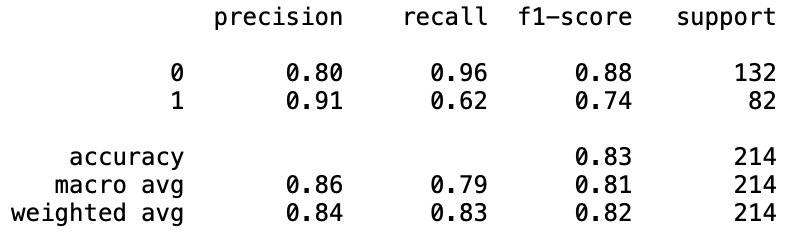

 ### CLASSIFICATION REPORT FOR MAX_DEPTH = 4
 
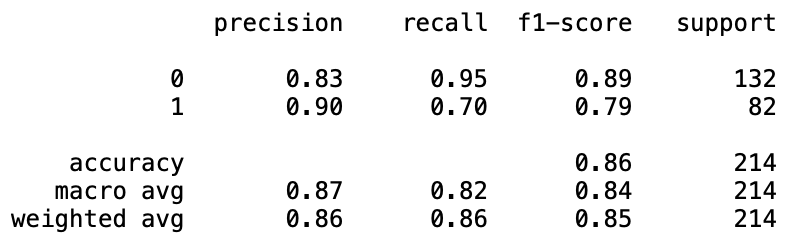

### CLASSIFICATION REPORT FOR MAX_DEPTH = 5

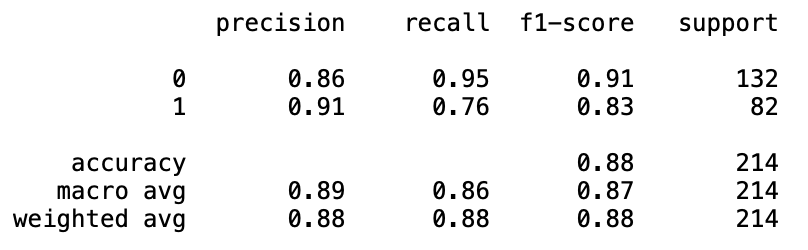

In [45]:
#adam's code for a nice, clean view:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 25):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.799197,0.761682,0.037515
1,3,0.825301,0.799065,0.026236
2,4,0.835341,0.794393,0.040949
3,5,0.853414,0.803738,0.049675
4,6,0.865462,0.789720,0.075742
5,7,0.885542,0.775701,0.109841
6,8,0.897590,0.785047,0.112544
7,9,0.921687,0.808411,0.113276
8,10,0.933735,0.785047,0.148688
9,11,0.959839,0.794393,0.165447


In [46]:
# here, we're comparing differences between the train and validate data sets
# we're tossing any differences above a certain amount (.10) and ordering by difference as a tie-breaker
df[df.difference <= 0.10].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

# the best max_depth, following these criteria, is 5

,max_depth,train_accuracy,validate_accuracy,difference
3,5,0.853414,0.803738,0.049675
1,3,0.825301,0.799065,0.026236
2,4,0.835341,0.794393,0.040949
4,6,0.865462,0.789720,0.075742
0,2,0.799197,0.761682,0.037515


# 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.


### baseline accuracy?

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
rf = RandomForestClassifier(max_depth = 10, )
rf

RandomForestClassifier(max_depth=10)

In [49]:
rf = rf.fit(X_train, y_train)
rf

RandomForestClassifier(max_depth=10)

In [50]:
print(rf.feature_importances_)

[0.08569171 0.21076705 0.05024383 0.03525351 0.24638559 0.02032253
 0.         0.30977629 0.01381987 0.02773963]


In [51]:
y_pred = rf.predict(X_train)
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [52]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

array([[7.67359659e-01, 2.32640341e-01],
       [3.10645995e-01, 6.89354005e-01],
       [9.58750000e-01, 4.12500000e-02],
       [2.75000000e-02, 9.72500000e-01],
       [0.00000000e+00, 1.00000000e+00],
       [8.65620739e-01, 1.34379261e-01],
       [8.94806333e-01, 1.05193667e-01],
       [9.54313767e-01, 4.56862332e-02],
       [9.86000000e-01, 1.40000000e-02],
       [9.99230769e-01, 7.69230769e-04],
       [7.78294872e-01, 2.21705128e-01],
       [9.14227389e-01, 8.57726110e-02],
       [4.60000000e-02, 9.54000000e-01],
       [7.32702687e-01, 2.67297313e-01],
       [8.62142706e-01, 1.37857294e-01],
       [5.89589562e-01, 4.10410438e-01],
       [9.48219153e-01, 5.17808474e-02],
       [2.06392496e-02, 9.79360750e-01],
       [6.24650489e-01, 3.75349511e-01],
       [8.71489316e-01, 1.28510684e-01],
       [1.11535256e-01, 8.88464744e-01],
       [9.66442514e-01, 3.35574860e-02],
       [1.00000000e-02, 9.90000000e-01],
       [2.04166667e-02, 9.79583333e-01],
       [6.339447

### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [53]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.97


In [54]:
conf_matrix = pd.DataFrame(confusion_matrix(y_train, y_pred))

conf_matrix
# confusion matrix - actual on left, predicted on top

# 0 = 'perished', 1= 'survived'

,0,1
0,307,0
1,16,175


In [55]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       307
           1       1.00      0.92      0.96       191

    accuracy                           0.97       498
   macro avg       0.98      0.96      0.97       498
weighted avg       0.97      0.97      0.97       498



### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [56]:
TP = 307
FP = 16
FN = 0
TN = 175
ALL = TP + FP + FN + TN

accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.9678714859437751
True Positive Rate: 1.0
False Positive Rate: 0.08376963350785341
True Negative Rate: 0.9162303664921466
False Negative Rate: 0.0
Precision: 0.9504643962848297
Recall: 1.0
F1 Score: 0.9746031746031747
Support (0): 307
Support (1): 191


### 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [57]:
#commenting out bc of longish processing time


# for i in range(20,1, -1):
#     for n in range(1, 21):
#         # Make the model
#         forest = RandomForestClassifier(max_depth=i, min_samples_leaf=n)#, random_state=123)

#         #why isn't the random_state argument working?

#         # Fit the model (on train and only train)
#         forest.fit(X_train, y_train)

#         # Use the model
#         # We'll evaluate the model's performance on train, first
#         y_predictions = forest.predict(X_train)

#         # Produce the classification report on the actual y values and this model's predicted y values
#         report = classification_report(y_train, y_predictions) #, output_dict=True)
#         print(f"Forest with max depth of {i} and sample leaves {n}")
#         print(report)
#         print()

- see about altering the for loop to just return accuracy, leaves and depth

### 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

    - this cell takes a while to run, so i'm commenting it out for now

In [58]:
# attempting to create lists that i can pack into a DF for easy comparison below
# create an empty list to fill in the for loop

# also, this for loop is creating a list of every possible min_samples_leaf for every max_depth
        # in other words, 20 max_depths * 20 min_leaves


metrics = []

for i in range(20,0, -1):
    for n in range(1, 21):
        # Make the model
        forest = RandomForestClassifier(max_depth=i, min_samples_leaf=n)#, random_state=123)

        #why isn't the random_state argument working?

        # Fit the model (on train and only train)
        forest.fit(X_train, y_train)

        # Use the model
        # We'll evaluate the model's performance on train, first
        in_sample_accuracy = forest.score(X_train, y_train)
    
        out_of_sample_accuracy = forest.score(X_validate, y_validate)

        output = {
            "max_depth": i,
            "min_leaves": n,
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy
        }

        metrics.append(output)

df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,min_leaves,train_accuracy,validate_accuracy,difference
0,20,1,0.995984,0.803738,0.192246
1,20,2,0.917671,0.817757,0.099914
2,20,3,0.901606,0.827103,0.074504
3,20,4,0.887550,0.808411,0.079139
4,20,5,0.873494,0.808411,0.065083
...,...,...,...,...,...
395,1,16,0.783133,0.757009,0.026123
396,1,17,0.775100,0.752336,0.022764
397,1,18,0.775100,0.757009,0.018091
398,1,19,0.789157,0.752336,0.036820


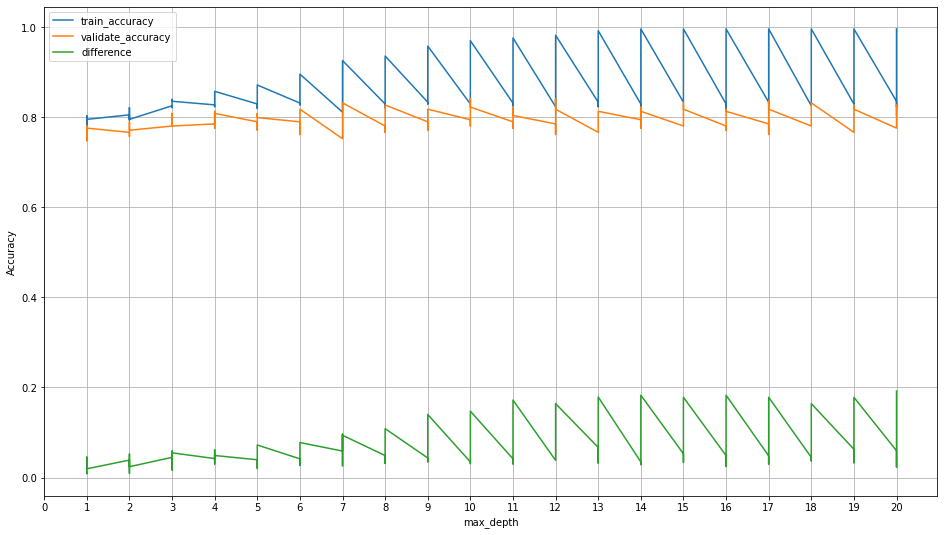

In [59]:
# df.set_index('max_depth').plot

# review ravinder's graph here

df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

### 6. After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [60]:
df[df.difference <= 0.1].sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True])

,max_depth,min_leaves,train_accuracy,validate_accuracy,difference
161,12,2,0.921687,0.841121,0.080565
201,10,2,0.923695,0.841121,0.082573
61,17,2,0.921687,0.836449,0.085238
62,17,3,0.903614,0.831776,0.071839
260,7,1,0.925703,0.831776,0.093927
...,...,...,...,...,...
396,1,17,0.775100,0.752336,0.022764
389,1,10,0.787149,0.752336,0.034812
398,1,19,0.789157,0.752336,0.036820
279,7,20,0.811245,0.752336,0.058909


# KNN EXERCISES

### 1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

In [61]:
X_train.head()

,pclass,age,sibsp,parch,fare,alone,baseline_prediction,sex_male,embark_town_Queenstown,embark_town_Southampton
583,1,36.000000,0,0,40.1250,1,0,1,0,0
165,3,9.000000,0,2,20.5250,0,0,1,0,1
50,3,7.000000,4,1,39.6875,0,0,1,0,1
259,2,50.000000,0,1,26.0000,0,0,0,0,1
306,1,29.678105,0,0,110.8833,1,0,0,0,0


In [62]:
from sklearn.neighbors import KNeighborsClassifier



In [63]:
#per Adam's lecture, we're getting rid of encoded columns here

x_cols = ['pclass', 'age', 'alone', 'fare']
y_col = 'survived'

X_train, y_train = train[x_cols], train[y_col]
X_validate, y_validate = validate[x_cols], validate[y_col]
X_test, y_test = test[x_cols], test[y_col]

In [64]:
X_train.head()

,pclass,age,alone,fare
583,1,36.000000,1,40.1250
165,3,9.000000,0,20.5250
50,3,7.000000,0,39.6875
259,2,50.000000,0,26.0000
306,1,29.678105,1,110.8833


In [65]:
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')

In [66]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [67]:
y_pred = knn.predict(X_train)
y_pred[0:5]

array([0, 1, 0, 1, 1])

In [68]:
y_pred_proba = knn.predict_proba(X_train)
knn.classes_, y_pred_proba[0:10]

(array([0, 1]),
 array([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]]))

### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [69]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.97


In [70]:
# confusion matrix - actual on left, predicted on top

# 0 = 'perished', 1= 'survived'

print(confusion_matrix(y_train, y_pred))

# do a crosstab with a pd. here

[[300   7]
 [  6 185]]


In [71]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       307
           1       0.96      0.97      0.97       191

    accuracy                           0.97       498
   macro avg       0.97      0.97      0.97       498
weighted avg       0.97      0.97      0.97       498



### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [72]:
# i love this: check out the .ravel function

TN, FP, FN, TP = confusion_matrix(y_train,y_pred).ravel()
ALL = TP + TN + FP + FN

TN, FP, FN, TP 

# also, adam has flipped this around so that '1' = 'survived'

(300, 7, 6, 185)

In [73]:
# check out the .ravel function of confusion_matrix()


accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.9738955823293173
True Positive Rate: 0.9685863874345549
False Positive Rate: 0.02280130293159609
True Negative Rate: 0.9771986970684039
False Negative Rate: 0.031413612565445025
Precision: 0.9635416666666666
Recall: 0.9685863874345549
F1 Score: 0.9660574412532636
Support (0): 191
Support (1): 307


### Run through steps 2-4 setting k to 10

In [74]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [75]:
y_pred = knn.predict(X_train)
y_pred[0:5]

array([1, 1, 0, 0, 1])

In [76]:
y_pred_proba = knn.predict_proba(X_train)
knn.classes_, y_pred_proba[0:10]

(array([0, 1]),
 array([[0.4, 0.6],
        [0.4, 0.6],
        [0.6, 0.4],
        [0.5, 0.5],
        [0.2, 0.8],
        [0.6, 0.4],
        [0.5, 0.5],
        [0.6, 0.4],
        [0.5, 0.5],
        [0.8, 0.2]]))

In [77]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.72


In [78]:
# confusion matrix - actual on left, predicted on top

# 0 = 'perished', 1= 'survived'

print(confusion_matrix(y_train, y_pred))

[[275  32]
 [106  85]]


In [79]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       307
           1       0.73      0.45      0.55       191

    accuracy                           0.72       498
   macro avg       0.72      0.67      0.68       498
weighted avg       0.72      0.72      0.70       498



### Run through setps 2-4 setting k to 20

In [80]:
knn = KNeighborsClassifier(n_neighbors=20, weights='uniform')
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=20)

In [81]:
y_pred = knn.predict(X_train)
y_pred[0:5]

array([0, 1, 0, 0, 1])

In [82]:
y_pred_proba = knn.predict_proba(X_train)
knn.classes_, y_pred_proba[0:10]

(array([0, 1]),
 array([[0.55, 0.45],
        [0.4 , 0.6 ],
        [0.6 , 0.4 ],
        [0.6 , 0.4 ],
        [0.3 , 0.7 ],
        [0.55, 0.45],
        [0.55, 0.45],
        [0.65, 0.35],
        [0.45, 0.55],
        [0.6 , 0.4 ]]))

In [83]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.71


In [84]:
# confusion matrix - actual on left, predicted on top

# 0 = 'perished', 1= 'survived'

print(confusion_matrix(y_train, y_pred))

[[272  35]
 [110  81]]


In [85]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79       307
           1       0.70      0.42      0.53       191

    accuracy                           0.71       498
   macro avg       0.71      0.66      0.66       498
weighted avg       0.71      0.71      0.69       498



### What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

- as the number of neighbors goes up, the accuracy goes down.  This must be bc as the neighbors increase,
- the estimated value of the target becomes closer to the mean of the whole set

### Which model performs best on our out-of-sample data from validate?

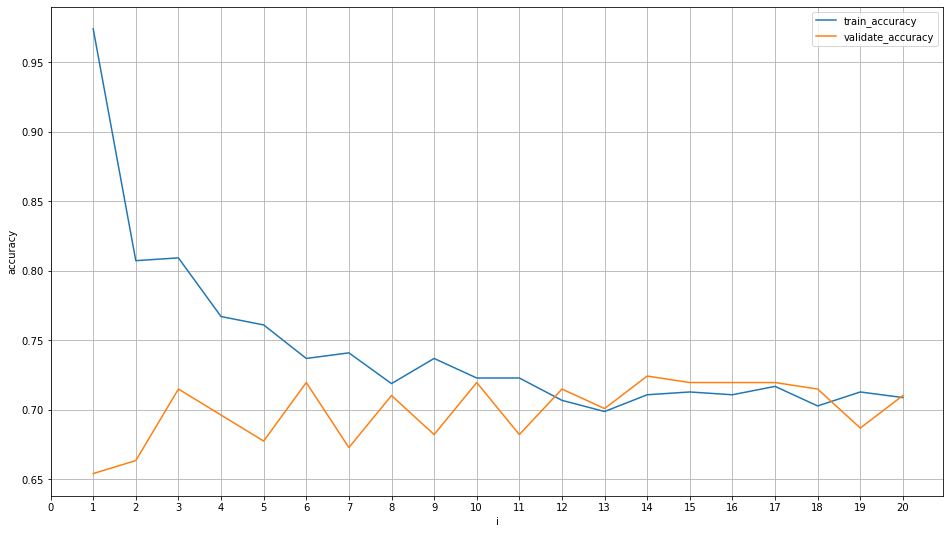

In [86]:
metrics = []

for i in range(1,21):
    # Make the model
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')


    # Fit the model (on train and only train)
    knn.fit(X_train, y_train)

    # We'll evaluate the model's performance on train and validate
    train_accuracy = knn.score(X_train, y_train)
    validate_accuracy = knn.score(X_validate, y_validate)

    output = {
        "i": i,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    metrics.append(output)
    # Produce the classification report on the actual y values and this model's predicted y values
results = pd.DataFrame(metrics)
    
# plot it
results.set_index('i').plot(figsize = (16,9))
plt.ylabel('accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [87]:
# 1 neighbor got us to 99% accuracy.  Is this overfit? sounds like it, from review

# In these exercises, we'll continue working with the titanic dataset and building logistic regression models. 
- Throughout this exercise, be sure you are training, evaluation, and comparing models on the train and validate datasets. The test dataset should only be used for your final model.

### For all of the models you create, choose a threshold that optimizes for accuracy.

In [88]:
train.head()


,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,baseline_prediction,sex_male,embark_town_Queenstown,embark_town_Southampton
583,583,0,1,male,36.000000,0,0,40.1250,Cherbourg,1,0,1,0,0
165,165,1,3,male,9.000000,0,2,20.5250,Southampton,0,0,1,0,1
50,50,0,3,male,7.000000,4,1,39.6875,Southampton,0,0,1,0,1
259,259,1,2,female,50.000000,0,1,26.0000,Southampton,0,0,0,0,1
306,306,1,1,female,29.678105,0,0,110.8833,Cherbourg,1,0,0,0,0


In [89]:
# the string features were causing problems with the DecisionTreeClassifier
X_train = train.drop(columns=['survived', 'sex','passenger_id', 'embark_town'])
y_train = train.survived

X_validate = validate.drop(columns=['survived', 'sex','passenger_id','embark_town'])
y_validate = validate.survived

X_test = test.drop(columns=['survived'])
y_test = test.survived

In [90]:
X_train.head()

,pclass,age,sibsp,parch,fare,alone,baseline_prediction,sex_male,embark_town_Queenstown,embark_town_Southampton
583,1,36.000000,0,0,40.1250,1,0,1,0,0
165,3,9.000000,0,2,20.5250,0,0,1,0,1
50,3,7.000000,4,1,39.6875,0,0,1,0,1
259,2,50.000000,0,1,26.0000,0,0,0,0,1
306,1,29.678105,0,0,110.8833,1,0,0,0,0


In [91]:
#i'm going to hold off on doing a 'for' loop for the moment.  issues with range and step: we want to start 
# at .1 and go up to as high as 1000

In [92]:
# Define the logistic regression model
logit = LogisticRegression(C=100)
#  fit the model on train data
logit.fit(X_train, y_train)

LogisticRegression(C=100)

In [93]:
# now use the model to make predictions
y_pred = logit.predict(X_train)
y_pred[0:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

In [94]:
logit.predict_proba(X_train)[0:10]

array([[0.67330125, 0.32669875],
       [0.81448394, 0.18551606],
       [0.97206272, 0.02793728],
       [0.1889842 , 0.8110158 ],
       [0.05591758, 0.94408242],
       [0.88012475, 0.11987525],
       [0.88268063, 0.11731937],
       [0.7571255 , 0.2428745 ],
       [0.89006013, 0.10993987],
       [0.9743272 , 0.0256728 ]])

In [95]:
# classification report


print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       307
           1       0.77      0.72      0.74       191

    accuracy                           0.81       498
   macro avg       0.80      0.79      0.80       498
weighted avg       0.81      0.81      0.81       498



### 1. Create a model that includes age in addition to fare and pclass. Does this model perform better than your baseline?

In [96]:
print(classification_report(y_train,X_train.baseline_prediction))

# see the baseline accuracy in its classification report

              precision    recall  f1-score   support

           0       0.62      1.00      0.76       307
           1       0.00      0.00      0.00       191

    accuracy                           0.62       498
   macro avg       0.31      0.50      0.38       498
weighted avg       0.38      0.62      0.47       498



In [101]:
baseline_accuracy = (train.survived == 0).mean()
round(baseline_accuracy, 3)

0.616

In [103]:
# teacher solution below; my classification report above resolved the question mostly

# Create the logistic regression
logit = LogisticRegression(random_state=123)

# specify the features we're using
features = ["age", "pclass", "fare"]

# Fit a model using only these specified features
# logit.fit(X_train[["age", "pclass", "fare"]], y_train)
logit.fit(X_train[features], y_train)

# Since we .fit on a subset, we .predict on that same subset of features
y_pred = logit.predict(X_train[features])

print("Baseline is", round(baseline_accuracy, 2))
print("Logistic Regression using age, pclass, and fare features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train[features], y_train)))

Baseline is 0.62
Logistic Regression using age, pclass, and fare features
Accuracy of Logistic Regression classifier on training set: 0.70


### 2. Include sex in your model as well. Note that you'll need to encode or create a dummy variable of this feature before including it in a model.

In [105]:
X_train.head()

,pclass,age,sibsp,parch,fare,alone,baseline_prediction,sex_male,embark_town_Queenstown,embark_town_Southampton
583,1,36.000000,0,0,40.1250,1,0,1,0,0
165,3,9.000000,0,2,20.5250,0,0,1,0,1
50,3,7.000000,4,1,39.6875,0,0,1,0,1
259,2,50.000000,0,1,26.0000,0,0,0,0,1
306,1,29.678105,0,0,110.8833,1,0,0,0,0


In [106]:
# Create the logistic regression
logit1 = LogisticRegression(random_state=123)

# specify the features we're using
features = ["age", "pclass", "fare", "sex_male"]

# Fit a model using only these specified features
logit1.fit(X_train[features], y_train)

y_pred = logit1.predict(X_train[features])

print("Logistic Regression using age, pclass, fare, and gender features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train[features], y_train)))

Logistic Regression using age, pclass, fare, and gender features
Accuracy of Logistic Regression classifier on training set: 0.81


### 3. Try out other combinations of features and models.

In [107]:
train.sample()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,baseline_prediction,sex_male,embark_town_Queenstown,embark_town_Southampton
670,670,1,2,female,40.0,1,1,39.0,Southampton,0,0,0,0,1


- Models Created:
- logit2, all Features, 0.81 accuracy
- logit3, all features with class_weight="balanced", .80 accuracy
- logit4, only age, .62 accuracy
- logit5, only pclass, .67 accuracy
- logit6, C hyperparameter close to zero, .62 accuracy

In [119]:
# all features
logit2 = LogisticRegression(random_state=123)
logit2.fit(X_train, y_train)
y_pred = logit2.predict(X_train)
logit2.score(X_train, y_train)

0.8172690763052208

In [120]:
# all features, class_weight = 'balanced'
logit3 = LogisticRegression(class_weight='balanced',random_state=123)
logit3.fit(X_train, y_train)
y_pred = logit3.predict(X_train)
logit3.score(X_train, y_train)

0.8072289156626506

In [122]:
# only age
features = ["age"]
logit4 = LogisticRegression(random_state=123)
logit4.fit(X_train[features], y_train)
y_pred = logit4.predict(X_train[features])
logit4.score(X_train[features], y_train)

0.6164658634538153

In [123]:
#pclass only
features = ["pclass"]
logit5 = LogisticRegression(random_state=123)
logit5.fit(X_train[features], y_train)
y_pred = logit5.predict(X_train[features])
logit5.score(X_train[features], y_train)

0.6666666666666666

In [127]:
# all features, c hyperparameter close to 0
logit6 = LogisticRegression(C=.00000001,random_state=123)
logit6.fit(X_train, y_train)
y_pred = logit6.predict(X_train)
logit6.score(X_train, y_train)

0.6164658634538153

### 4. Use you best 3 models to predict and evaluate on your validate sample.
- choose from any of the model types

In [ ]:
# best accuracy was using all features at approx 82%

### 5. Choose you best model from the validation performation, and evaluate it on the test dataset. How do the performance metrics compare to validate? to train?

In [129]:
# Create the logistic regression
logit1 = LogisticRegression(random_state=123)

# specify the features we're using
features = ["age", "pclass", "fare", "sex_male"]

# Fit a model using only these specified features
logit1.fit(X_validate[features], y_validate)

y_pred = logit1.predict(X_validate[features])

print("Logistic Regression using age, pclass, fare, and gender features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_validate[features], y_validate)))

Logistic Regression using age, pclass, fare, and gender features
Accuracy of Logistic Regression classifier on training set: 0.79


In [130]:
# all features
logit2 = LogisticRegression(random_state=123)
logit2.fit(X_validate, y_validate)
y_pred = logit2.predict(X_validate)
logit2.score(X_validate, y_validate)

0.7990654205607477

What next?
- Consider the precision and recall values from each model.
- Experiment with more hyperparameter values and combinations
- Handle the age nulls differently
- We could try filling the nulls with median age instead of average age
- We could drop the nulls if they weren't such a large proportion of the dataset
- Feature engineering
- Handling outliers
- Scaling (we'll do this later)

Once we have a single model doing really well on validate, then we'll select that model to evaluate on test.

### bonus and extra bonus

# Please see ravinder's neat code in the exercise review